In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

import tensorflow as tf
tf.random.set_seed(1)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Times New Roman']
mpl.rcParams['font.size'] = 18

In [3]:
df = pd.read_csv("data/2018_r.csv")

In [4]:
weath_vars = ["MONTH", "HOUR", "TEMPERATURE", "WIND_SPEED", "HUMIDITY", "AIR_PRESSURE", "WIND_DIRECTION"]
traff_vars = ["MONTH", "HOUR", "ROAD_1", "ROAD_2", "ROAD_3", "ROAD_4", "ROAD_5", "ROAD_6", "ROAD_7", "ROAD_8"]
total_vars = ["MONTH", "HOUR", "DAYOFYEAR", "DAYOFWEEK", "TEMPERATURE", "WIND_SPEED", "HUMIDITY", "AIR_PRESSURE", "WIND_DIRECTION", "ROAD_1", "ROAD_2", "ROAD_3", "ROAD_4", "ROAD_5", "ROAD_6", "ROAD_7", "ROAD_8"]

input_vars = total_vars
output_var = "PM10"
predict_hour = 1

input_vars.insert(0, output_var)
input_vars

['PM10',
 'PM10_diff',
 'MONTH',
 'HOUR',
 'DAYOFYEAR',
 'DAYOFWEEK',
 'TEMPERATURE',
 'WIND_SPEED',
 'HUMIDITY',
 'AIR_PRESSURE',
 'WIND_DIRECTION',
 'ROAD_1',
 'ROAD_2',
 'ROAD_3',
 'ROAD_4',
 'ROAD_5',
 'ROAD_6',
 'ROAD_7',
 'ROAD_8']

In [5]:
df[output_var] = df[output_var].shift(-predict_hour)
df[output_var] = df[output_var].interpolate()

In [6]:
training_set = df[input_vars].values
training_set.shape

(8760, 19)

In [7]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = MinMaxScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[0.14527027],
       [0.14189189],
       [0.12837838],
       ...,
       [0.17567568],
       [0.18918919],
       [0.18918919]])

In [8]:
X = []
y = []

n_future = 0
n_past = 24

for i in range(n_past, len(training_set_scaled) - n_future+1):
    X.append(training_set_scaled[i - n_past: i, 1: training_set.shape[1]])
    y.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
    
X, y = np.array(X), np.array(y)

X.shape, y.shape

((8737, 24, 18), (8737, 1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True) # 17

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6989, 24, 18), (6989, 1), (1748, 24, 18), (1748, 1))

In [11]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(n_past, X.shape[2])))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           75264     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 24, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath='data/weights_%s.h5' % output_var, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = tf.keras.callbacks.TensorBoard('data/logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=64)

# model.save("data/model_%s" % (output_var))

Epoch 1/100
 1/88 [..............................] - ETA: 0s - loss: 0.0985WARNING:tensorflow:From d:\coding\jupyterlab\env\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
87/88 [============================>.] - ETA: 0s - loss: 0.0594
Epoch 00001: val_loss improved from inf to 0.00605, saving model to data\weights_PM10.h5
88/88 [==============================] - 5s 52ms/step - loss: 0.0592 - val_loss: 0.0061
Epoch 2/100
87/88 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 00002: val_loss improved from 0.00605 to 0.00559, saving model to data\weights_PM10.h5
88/88 [==============================] - 3s 34ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 3/100
86/88 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 00003: val_loss improved from 0.00559 to 0.00387, saving model 

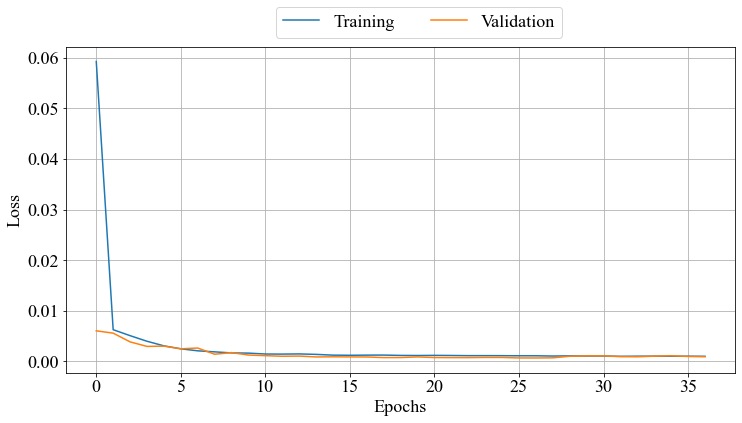

In [13]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc=2, ncol=2, bbox_to_anchor=(0.3, 1.15))
plt.show()

In [14]:
y_pred = model.predict(X_test)

In [15]:
y_test_inv = sc_predict.inverse_transform(y_test)
y_pred_inv = sc_predict.inverse_transform(y_pred)

In [16]:
y_pred[:1]

array([[0.17638788]], dtype=float32)

In [17]:
print(input_vars)
print("predict_hour: ", predict_hour)
print('R^2: %.2f' % (r2_score(y_test_inv, y_pred_inv) * 100))
print('RMSE: %.2f' % (np.sqrt(mse(y_test_inv, y_pred_inv))))
print('MAE: %.2f' % (mae(y_test_inv, y_pred_inv)))

['PM10', 'PM10_diff', 'MONTH', 'HOUR', 'DAYOFYEAR', 'DAYOFWEEK', 'TEMPERATURE', 'WIND_SPEED', 'HUMIDITY', 'AIR_PRESSURE', 'WIND_DIRECTION', 'ROAD_1', 'ROAD_2', 'ROAD_3', 'ROAD_4', 'ROAD_5', 'ROAD_6', 'ROAD_7', 'ROAD_8']
predict_hour:  1
R^2: 83.34
RMSE: 9.73
MAE: 6.95


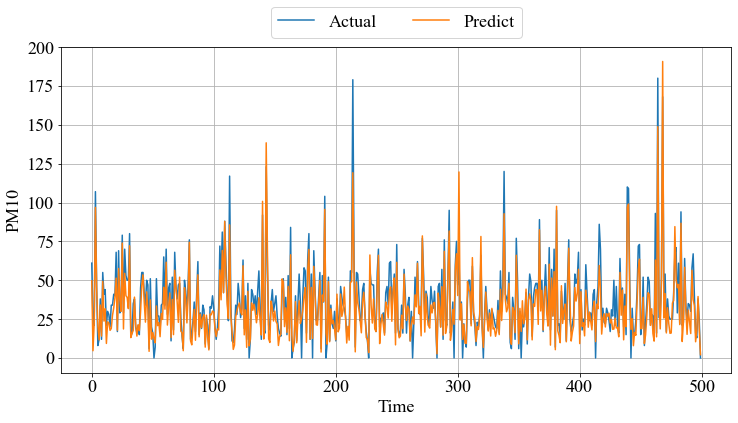

In [18]:
plt.plot(y_test_inv[-500:], label="Actual")
plt.plot(y_pred_inv[-500:], label="Predict")
plt.ylabel(output_var)
plt.xlabel("Time")
plt.legend(loc=2, ncol=2, bbox_to_anchor=(0.3, 1.15))
plt.show()